# Tree Classifier
A good description of decision tree can be found [here](http://mines.humanoriented.com/classes/2010/fall/csci568/portfolio_exports/lguo/decisionTree.html)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
np.random.seed(42)

In [2]:
def my_test_results(model, X, Y):
    cm = confusion_matrix((Y == 1), (model.predict(X) > 0.5), labels=[0, 1])
    accuracy = (cm[0, 0] + cm[1, 1])/sum(sum(cm))
    precision = float(cm[1, 1]/(cm[1, 1]+cm[0, 1]))
    recall = float(cm[1, 1]/(cm[1, 1]+cm[1, 0]))
    f1 = (2.0*precision*recall)/(precision+recall)
    print("Out of sample accuracy = %4.3f" % accuracy)
    print("Out of sample precision = %4.3f" % precision)
    print("Out of sample recall = %4.3f" % recall)
    print("Out of sample F1 = %4.3f" % f1)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])

### Import Data

* Load data
* Remove useless columns and records (only CASH_OUT and TRANSFER have fraud).
* Remap transfer to 0/1.

In [3]:
df = pd.read_csv('../simulated_transactions.csv.xz')
print(df.shape)
df.head()

(1305514, 11)


step     type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     2  PAYMENT   18211.33  C1099717276          88.00            0.00   
1     2  CASH_IN   93240.07  C1350751778          47.00        93287.07   
2     2  CASH_IN   78314.86   C332699949       93287.07       171601.93   
3     2  CASH_IN  101282.39   C808417649      171601.93       171601.93   
4     2  CASH_IN   24227.29   C858204589      171601.93       195829.22   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0   M417557780            0.00            0.00        0               0  
1   C665576141           12.00      8650239.39        0               0  
2  C1359044626       178957.00     16435074.66        0               0  
3  C1599771323       171601.93      3771328.56        0               0  
4   C353842779       524999.00       872623.24        0               0

### Filtering
Filter out types other than TRANSFER, and CASH_OUT.<br>
Remove variables, 'step', 'nameOrig', 'nameDest', and 'isFlaggedFraud'.

In [4]:
df_filtered = df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'],
                      axis=1).query('type == "CASH_OUT" or type == "TRANSFER"')
df_filtered.loc[df_filtered.type == 'TRANSFER', 'type'] = 0
df_filtered.loc[df_filtered.type == 'CASH_OUT', 'type'] = 1
print(df_filtered.shape)

(586965, 7)


## Decision Tree Classifier
Begin preparing for the model

### Training Set
Partition the data with an 80/20 split: Training/Testing. <br>
Separate out the dependent variable from the independent varaibles.

In [5]:
train, test = train_test_split(df_filtered, test_size=0.2,
                               stratify=df_filtered['isFraud'])

Y_train = train['isFraud']
X_train = train.drop(['isFraud'], axis=1)

Y_test = test['isFraud']
X_test = test.drop(['isFraud'], axis=1)

### Default Decision Tree Classifier
Plug data into sklearn's decision tree classifier.

Out of sample accuracy = 0.999
Out of sample precision = 0.982
Out of sample recall = 0.971
Out of sample F1 = 0.977


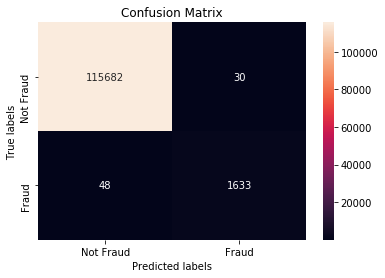

In [6]:
mymodel = tree.DecisionTreeClassifier()

dt = mymodel.fit(X_train, Y_train)
my_test_results(dt, X_test, Y_test)

* Accuracy - Proportion of predictions that are correct. $\frac{True Positive + True Negative}{True Positive + True Negative + False Positive + False Negative}$
* Precision - True positive over total positive actual cases. $\frac{True Positive}{True Positive + False Positive}$
* Recall - True positive over total positive predicted cases. $\frac{True Positive}{True Positive + False Negative}$
* F1 - A balance between Precision and Recall (harmonic mean of precision and recall) $\frac{2 * Precision * Recall}{Precision + Recall}$

That's not bad at all.<br>
The best part of using trees is that they are often easy to interpret. 

### Plot the tree

In [7]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,
                filled=True, rounded=True,
                feature_names=X_train.columns,
                class_names=list(['Not Fraud', 'Fraud']),
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

This tree is too deep to fully read quickly and easily.

### Plot tree with less depth

In [8]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, max_depth=2,
                filled=True, rounded=True,
                feature_names=X_train.columns,
                class_names=list(['Not Fraud', 'Fraud']),
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

A quick scan of the down the blue path is interesting. It shows that we can catch over 1/2 of the fraud without a large false positive rate by just flagging accounts where:
* The balance before the transaction was greater than ~ 1.58mm
* The balance after the transaction was less than ~ 6.8k

i.e., Large balances were suddenly cleaned out.

### Summary
In general, a decision tree does not perform as well as many other classifiers. e.g., Neural Nets, Random Forests, etc. They are fast and easy to make, and especially easy to interpret. In some cases, deployment into production could merely be easy to code rules. It may be possible to insert them into manual processes.<br>
In this example, even if the ideal solution is a complex model behind a RESTful API. A simple rule: e.g., flag transactions greater than 1mm that bring the balance to less than 10k could be instituted by the end of the day.